In [2]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [3]:
using Statistics
using NiLang
using BenchmarkTools


┌ Info: Precompiling NiLang [ab4ef3a6-0b42-11ea-31f6-e34652774712]
└ @ Base loading.jl:1278


In [4]:
#提取日线沪深300指数收盘价
a= readlines("F:\\我的坚果云\\julia\\策略微分\\data.txt");
b=parse.(Float64,a);
b2=copy(b);


In [5]:
#EMA权重
bili=0.0952;
n=length(b);
ma=zeros(n,1);
ma[1]=b[1];
pos=zeros(n,1);
#单位净值
jinzhi=ones(n,1);
for i =2:n
    if pos[i-1]>0
        #如果信号为正,做多
        jinzhi[i]=jinzhi[i-1]*(b[i]/b[i-1]);
    elseif pos[i-1]<0
        #如果信号为负,做空
        jinzhi[i]=jinzhi[i-1]*(2-b[i]/b[i-1]);
    else
        #如果信号为0,保持不变
        jinzhi[i]=jinzhi[i-1];
    end
    #计算EMA
    ma[i]=b[i]*bili+(1-bili)*ma[i-1];

    pos[i] = -tanh(ma[i]-b[i]);

end


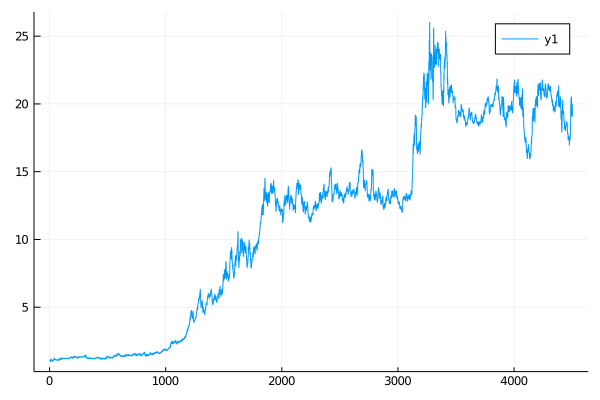

In [6]:
plot(jinzhi)

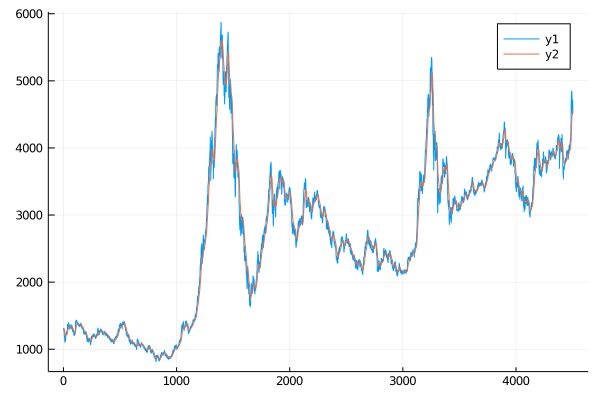

In [7]:
plot(b)
plot!(ma)

In [8]:
@i function jin(out::T,b::AbstractVector{T},ma::AbstractVector{T},jinzhi::AbstractVector{T},pos::AbstractVector{T},bili::T) where T
    @routine begin
        for i =2:length(b)

            if (pos[i-1]!=0, ~)
                @routine begin
                    # use `@zeros TYPE vars...` to add ancillas
                    @zeros T anc1 anc2
                    # !note: one operations a time, it should be `y += f(x)` or `y += x`.
                    anc1 += b[i] / b[i-1]
                    anc1 -= 1.0
                    anc2 += anc1 * pos[i-1]
                    #anc2 += 1.0
                end

                jinzhi[i] += anc2
                jinzhi[i] -= 0.0001
                ~@routine
            end

            ma[i] += b[i] * bili
            bili -= 1.0
            ma[i] -= bili * ma[i-1]
            bili += 1.0


            # the relaxed version
            ma[i] -= b[i]
            pos[i] -= tanh(ma[i])
            ma[i] += b[i]
        end
        @zeros T var varsum mean sum std
        NiLang.i_var_mean_sum(var, varsum, mean, sum, jinzhi)
        std += sqrt(var)
    end
    #计算夏普率
    out += mean/std 
    ~@routine
end
    

In [9]:
bili=0.0952;
n=length(b);
ma=zeros(n);
ma[1]=b[1];
jinzhi=zeros(n);
#jinzhi[1]=1.0;
pos=zeros(n);
out=0.0;
# check the reversibility
check_inv(jin, (out,b,ma,jinzhi,pos,bili))


true

In [10]:
# check the gradients with numeric gradients
NiLang.AD.check_grad(jin, (out,b,ma,jinzhi,pos,bili); iloss=1)

false

In [11]:
out,b,ma,jinzhi,pos,bili=jin(out,b,ma,jinzhi,pos,bili)


(0.04168701867765715, [1316.4600000000003, 1302.0800000000002, 1292.7100000000003, 1272.6500000000003, 1281.2600000000002, 1249.8100000000002, 1205.1500000000003, 1186.4300000000003, 1201.8800000000003, 1152.1500000000003  …  4806.69, 4744.47, 4516.25, 4544.7, 4680.3, 4691.04, 4714.45, 4712.44, 4505.59, 4512.86], [1316.4600000000003, 5.400124791776761e-13, 8.526512829121202e-14, 1.8474111129762605e-13, 2.7000623958883807e-13, 2.4158453015843406e-13, 2.5579538487363607e-13, 2.2737367544323206e-13, 1.8474111129762605e-13, 3.268496584496461e-13  …  -6.252776074688882e-13, 4.547473508864641e-13, 4.433786671143025e-12, -7.958078640513122e-12, 2.2737367544323206e-12, 1.0231815394945443e-11, -3.979039320256561e-13, 1.1368683772161603e-12, -4.547473508864641e-13, 1.1937117960769683e-12], [0.0, -1.0842021724855044e-19, -8.673617379884035e-19, 0.0, 8.673617379884035e-19, 3.469446951953614e-18, -1.3877787807814457e-17, 0.0, 0.0, -1.3877787807814457e-17  …  0.0, 0.0, -1.3877787807814457e-17, 2.602

In [12]:
out,b,ma,jinzhi,pos,bili=(~jin)(out,b,ma,jinzhi,pos,bili)

(0.0, [1316.4600000000003, 1302.0800000000002, 1292.7100000000003, 1272.6500000000003, 1281.2600000000002, 1249.8100000000002, 1205.1500000000003, 1186.4300000000003, 1201.8800000000003, 1152.1500000000003  …  4806.69, 4744.47, 4516.25, 4544.7, 4680.3, 4691.04, 4714.45, 4712.44, 4505.59, 4512.86], [1316.4600000000003, 5.400124791776761e-13, 8.526512829121202e-14, 1.8474111129762605e-13, 2.7000623958883807e-13, 2.4158453015843406e-13, 2.5579538487363607e-13, 2.2737367544323206e-13, 1.8474111129762605e-13, 3.268496584496461e-13  …  -6.252776074688882e-13, 4.547473508864641e-13, 4.433786671143025e-12, -7.958078640513122e-12, 2.2737367544323206e-12, 1.0231815394945443e-11, -3.979039320256561e-13, 1.1368683772161603e-12, -4.547473508864641e-13, 1.1937117960769683e-12], [0.0, -1.0842021724855044e-19, -8.673617379884035e-19, 0.0, 8.673617379884035e-19, 3.469446951953614e-18, -1.3877787807814457e-17, 0.0, 0.0, -1.3877787807814457e-17  …  0.0, 0.0, -1.3877787807814457e-17, 2.6020852139652106e-1

In [13]:
gout,gb,gma,gjinzhi,gpos,gbili= NiLang.AD.gradient(Val(1), jin, (out,b,ma,jinzhi,pos,bili))

(1.0, [0.0, 9.70553516963622e-6, -6.847015751776566e-7, 3.938910345528847e-7, -1.6093969756637697e-6, -9.251139446543512e-7, 1.8546344681908925e-7, 4.963987894739892e-7, -2.7948391355946037e-6, 7.711718381583639e-7  …  -1.3863729431922025e-8, -1.351696886891432e-7, 2.2754401660079914e-7, 1.114480999407906e-7, -1.2583705746869063e-7, 1.1806265842064889e-8, -2.350066872371062e-8, -1.734595017413792e-7, 6.161654779227228e-6, -2.9927813108849022e-6], [-3.319811477528266e-6, -3.6691108283910985e-6, -4.055162279275141e-6, -4.481832757819563e-6, -4.953396063018968e-6, -5.474575666466587e-6, -6.050592027482965e-6, -6.687214884486035e-6, -7.390821048282531e-6, -8.168458276174327e-6  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.01342644790536296, 0.01342644790536296, 0.01318709562806275, 0.012906409865163098, 0.013658016448535551, 0.012601885542665298, 0.01222454140502435, 0.012905885438928196, 0.013869058369931147, 0.012034190584426771  …  0.013751413315478711, 0.013866434148782872,

In [14]:
 @benchmark gout,gb,gma,gjinzhi,gpos,gbili= NiLang.AD.gradient(Val(1), jin, (out,b,ma,jinzhi,pos,bili))

BenchmarkTools.Trial: 
  memory estimate:  423.69 KiB
  allocs estimate:  35
  --------------
  minimum time:     587.921 μs (0.00% GC)
  median time:      649.928 μs (0.00% GC)
  mean time:        680.541 μs (4.93% GC)
  maximum time:     4.422 ms (85.02% GC)
  --------------
  samples:          7331
  evals/sample:     1

1 0.6617609059247126
2 0.6619451499615379
3 0.6621415673850978
4 0.6623514583660971
5 0.6625760205737918
6 0.6628162542615275
7 0.6630728606412326
8 0.6633461477808615
9 0.6636359626582584
10 0.6639416686421148
11 0.6642621827581908
12 0.6645960767733257
13 0.6649417330724504
14 0.6652975349334649
15 0.665662065228186
16 0.6660342895446228
17 0.6664137079622089
18 0.666800470924131
19 0.6671954654022679
20 0.6676003857490003
21 0.6680178090691462
22 0.6684512990620521
23 0.6689055677972543
24 0.6693867360021155
25 0.669902756396515
26 0.6704641159902305
27 0.6710850448520649
28 0.6717857096853462
29 0.6725964619297293
30 0.673566678646268
31 0.674784512907802
32 0.6764230002230078
33 0.6788369023231836
34 0.6825909340704163
35 0.6874746552402523
36 0.6916472062393568
37 0.6948566564420049
38 0.6976835260375996
39 0.700336297041418
40 0.7028288331679473
41 0.7051129282474582
42 0.7071400492705073
43 0.7088837971389429
44 0.710341381740758
45 0.7115285421203396
46 0.7124736243936723
47 0

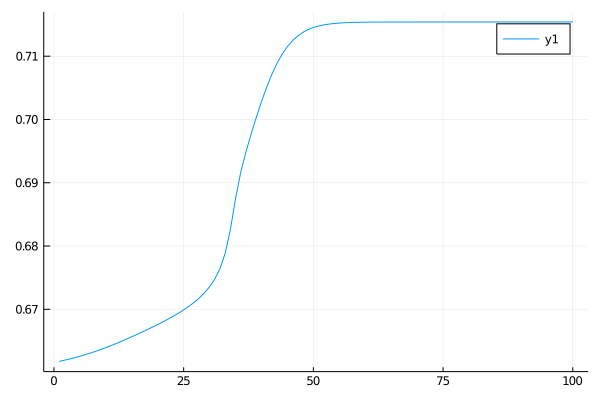

In [15]:
bili=0.0952;
steps=0.0001;
N=100;
sharpe=[];
for i=1:N

    out,b,ma,jinzhi,pos,bili=jin(out,b,ma,jinzhi,pos,bili);
    println(i," ",out*sqrt(252))
    push!(sharpe,out*sqrt(252))
    out,b,ma,jinzhi,pos,bili=(~jin)(out,b,ma,jinzhi,pos,bili);
    gout,gb,gma,gjinzhi,gpos,gbili= NiLang.AD.gradient(Val(1), jin, (out,b,ma,jinzhi,pos,bili));
    bili+=gbili*steps;

end

print(bili)
plot(sharpe)




 1.7783187727023941
111 1.7825739575448802
112 1.786784193362077
113 1.7909675898211055
114 1.795142693168785
115 1.7993282301965798
116 1.803538456739662
117 1.8077915310243071
118 1.812150454814759
119 1.8168582176241774
120 1.82264837509383
121 1.828617709612768
122 1.8372826711650005
123 1.8559321823732877
124 1.8602306000231073
125 1.8651472378475726
126 1.8747448388197168
127 1.8825525867633381
128 1.886577260726136
129 1.8906163742000626
130 1.8946764173042487
131 1.8987679623644642
132 1.9029155705218632
133 1.9071803269102603
134 1.9116513082377387
135 1.9161556256195524
136 1.9203502031887054
137 1.9244076792365896
138 1.928466482949224
139 1.932628610175044
140 1.9371523548504708
141 1.9426533087093016
142 1.9478329825764449
143 1.9525349225922553
144 1.958520313499918
145 1.9634160576997535
146 1.9675114729368033
147 1.972151265950384
148 1.9802525169898268
149 1.9866846455276463
150 1.9903385184877678
151 1.9939741607383183
152 1.9975939617299525
153 2.0011990051357933
154

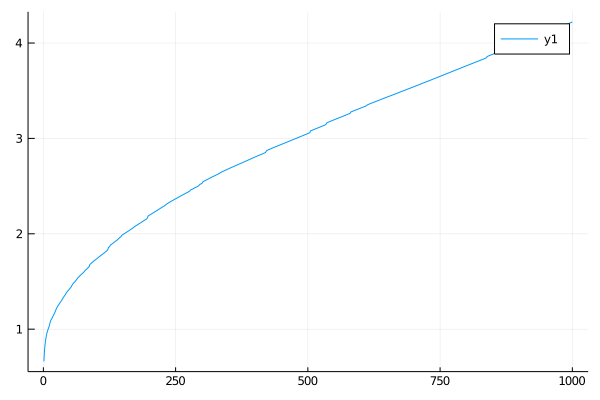

In [16]:
b=parse.(Float64,a);
bili=0.0952;
steps=10000;
N=1000;
sharpe=[];
for i=1:N

    out,b,ma,jinzhi,pos,bili=jin(out,b,ma,jinzhi,pos,bili);
    println(i," ",out*sqrt(252))
    push!(sharpe,out*sqrt(252))
    out,b,ma,jinzhi,pos,bili=(~jin)(out,b,ma,jinzhi,pos,bili);
    gout,gb,gma,gjinzhi,gpos,gbili= NiLang.AD.gradient(Val(1), jin, (out,b,ma,jinzhi,pos,bili));
    b+=gb*steps;

end


plot(sharpe)




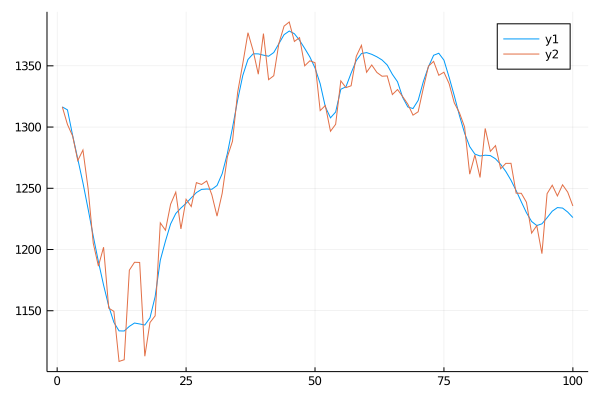

In [17]:

plot(b[1:100])
plot!(b2[1:100])

In [18]:
@i function r_axpy!(a::T, x::AbstractVector{T}, y!::AbstractVector{T}) where T
    @safe @assert length(x) == length(y!)
    for i=1:length(x)
        y![i] += a * x[i]
    end
end

@i function r_loss(out!, a, x, y!, z)
    r_axpy!(a, x, y!)
    for i=1:length(z)
    	out! += z[i] * y![i]
    end
end

In [19]:
using Zygote


In [20]:

function jin2(b,bili) 
    ma=Zygote.Buffer(b, length(b), 1);
    ma[1]=b[1];
    pos=Zygote.Buffer(b, length(b), 1);
    pos[1]=0;
    ret=Zygote.Buffer(b, length(b), 1);
    ret[1]=0;
    for i =2:length(b)
        ret[i]=(b[i]/b[i-1]-1)*pos[i-1];
        ret[i]-=0.0001;
        ma[i]=b[i]*bili+(1-bili)*ma[i-1];
        pos[i] = -tanh(ma[i]-b[i]);
    end
    a=copy(ret);
    return mean(a)/std(a)
end


jin2 (generic function with 1 method)

In [21]:
bili=0.0952;
b=parse.(Float64,a);
jin2(b, bili)


0.04168567586434463

In [22]:
gradient(x -> jin2(b, x), bili)

(-0.33799710814098677,)

In [23]:
@benchmark gradient(x -> jin2(b, x), bili)

BenchmarkTools.Trial: 
  memory estimate:  1.23 GiB
  allocs estimate:  730694
  --------------
  minimum time:     410.611 ms (27.32% GC)
  median time:      466.179 ms (25.88% GC)
  mean time:        460.436 ms (27.33% GC)
  maximum time:     531.938 ms (27.95% GC)
  --------------
  samples:          12
  evals/sample:     1